In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.linear_model import LinearRegression
pd.set_option('display.max_columns',100)

### READING THE FILE

In [2]:
csv_file_path = 'data_file/data.csv'
df = pd.read_csv(csv_file_path)

### TYPE CASTING THE START AND END TIME COLUMNS TO DATETIME FORMAT

In [3]:
df['Start Time'] = pd.to_datetime(df['Start Time'], format='%Y-%m-%dT%H:%M:%S')
df['End Time'] = pd.to_datetime(df['End Time'], format='%Y-%m-%dT%H:%M:%S')

In [4]:
df['Vessel Name'].value_counts()

Vessel Name
Vessel 1    105120
Vessel 2    105120
Name: count, dtype: int64

In [5]:
df1 = df[df['Vessel Name']=='Vessel 1']
df2 = df[df['Vessel Name']=='Vessel 2']

### VESSEL 1

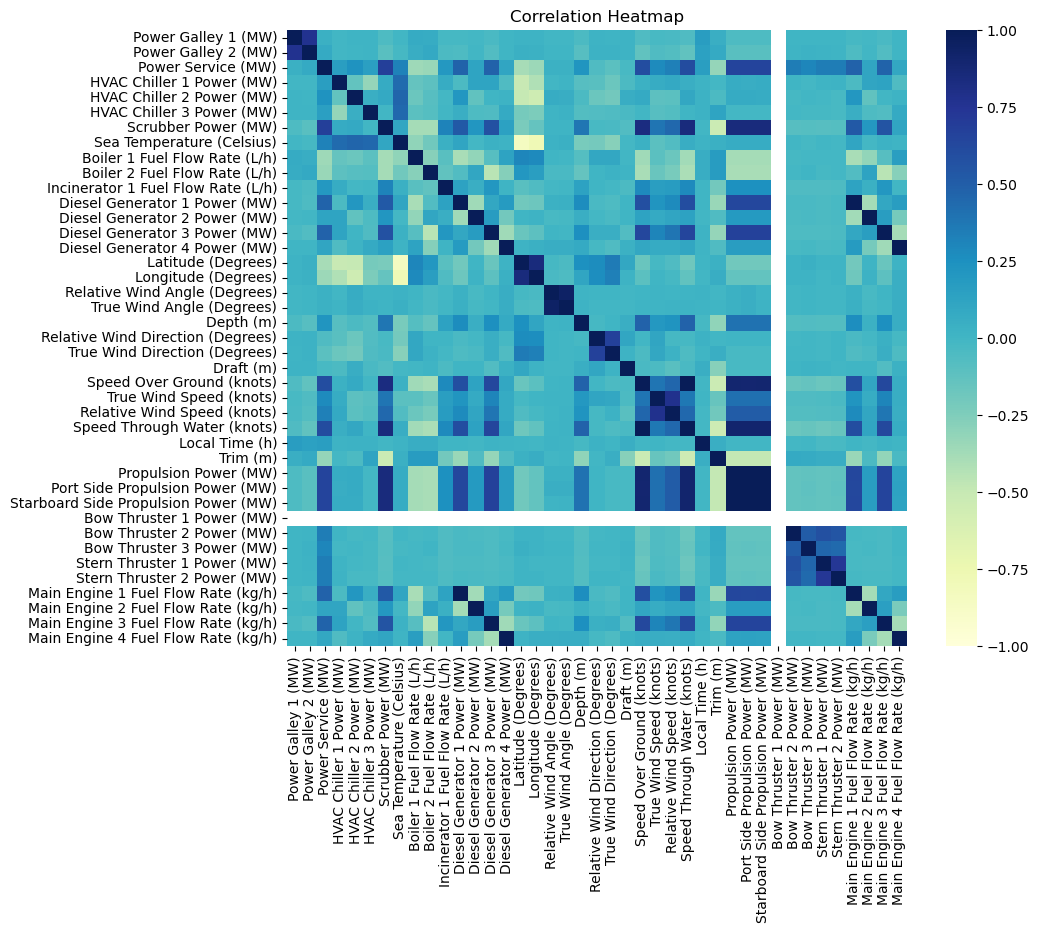

In [6]:
df_correlation = df1.corr(method='pearson', numeric_only=True)
df_correlation
     
plt.figure(figsize=(10, 8))
sns.heatmap(df_correlation, annot=False, cmap='YlGnBu', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

#### FIXING NULL VALUES

In [7]:
df1.isnull().sum()

Start Time                                  0
End Time                                    0
Vessel Name                                 0
Power Galley 1 (MW)                         1
Power Galley 2 (MW)                         1
Power Service (MW)                          1
HVAC Chiller 1 Power (MW)                   1
HVAC Chiller 2 Power (MW)                   1
HVAC Chiller 3 Power (MW)                   1
Scrubber Power (MW)                         1
Sea Temperature (Celsius)                   1
Boiler 1 Fuel Flow Rate (L/h)               1
Boiler 2 Fuel Flow Rate (L/h)               1
Incinerator 1 Fuel Flow Rate (L/h)          1
Diesel Generator 1 Power (MW)               1
Diesel Generator 2 Power (MW)               1
Diesel Generator 3 Power (MW)               1
Diesel Generator 4 Power (MW)               1
Latitude (Degrees)                          0
Longitude (Degrees)                         0
Relative Wind Angle (Degrees)               0
True Wind Angle (Degrees)         

In [8]:
df1 = df1.dropna(subset=['Power Galley 1 (MW)'])

#Wherever speed over ground is 0 and True Wind Angle (Degrees) is null, filling it with Relative Wind Angle (Degrees)
df1['True Wind Angle (Degrees)'] = np.where(df1['True Wind Angle (Degrees)'].isnull(), df1['Relative Wind Angle (Degrees)'], df1['True Wind Angle (Degrees)'])
df1['True Wind Speed (knots)'] = np.where(df1['True Wind Speed (knots)'].isnull(), df1['Relative Wind Speed (knots)'], df1['True Wind Speed (knots)'])

### USING LINEAR REGRESSION TO IMPUTE NULL VALUES FOR SPEED THROUGH WATER LOOKING AT THE CORRELATION

In [9]:
df1_non_missing = df1[df1['Speed Through Water (knots)'].notnull()]
df1_missing = df1[df1['Speed Through Water (knots)'].isnull()]

# Train a linear regression model using non-missing values
X = df1_non_missing[['Scrubber Power (MW)', 'Speed Over Ground (knots)', 'Propulsion Power (MW)']]  # Predictor (SOG)
y = df1_non_missing['Speed Through Water (knots)']  # Target (STW)

model = LinearRegression()
model.fit(X, y)

# Predict the missing STW values using the SOG values
predicted_stw = model.predict(df1_missing[['Scrubber Power (MW)', 'Speed Over Ground (knots)', 'Propulsion Power (MW)']])

# Impute the missing values
df1.loc[df1['Speed Through Water (knots)'].isnull(), 'Speed Through Water (knots)'] = predicted_stw


In [10]:
#df1.to_excel('data_file/vessel1_data.xlsx', index = False)

Visualizing Vessel 1 Route

In [11]:
import pandas as pd
import folium
from folium.plugins import AntPath
from geopy.distance import geodesic

# Create a folium map centered on the mean location
mean_lat = df1['Latitude (Degrees)'].mean()
mean_lon = df1['Longitude (Degrees)'].mean()

# Initialize the map at the central location
m = folium.Map(location=[mean_lat, mean_lon], zoom_start=6)

# Create a list of latitude and longitude pairs for the path
coordinates = list(zip(df1['Latitude (Degrees)'], df1['Longitude (Degrees)']))

# Add an AntPath (or Line) to represent the ship's path
folium.PolyLine(locations=coordinates, color="blue", weight=2.5, opacity=1).add_to(m)

# Save the map to an HTML file and display it
m.save('ship_route_map_1.html')


Analysis of Power Consumption of Vessel 1

Total Power Consumption (Monthly)

C:\Users\Keertisuryawanshi\AppData\Local\Temp\ipykernel_24560\2786133357.py:21: FutureWarning: 'bM' is deprecated and will be removed in a future version, please use 'BME' instead.
  df_vessel_1_resampled = df_copy[numeric_columns].resample('bM').sum()  # Resample by month


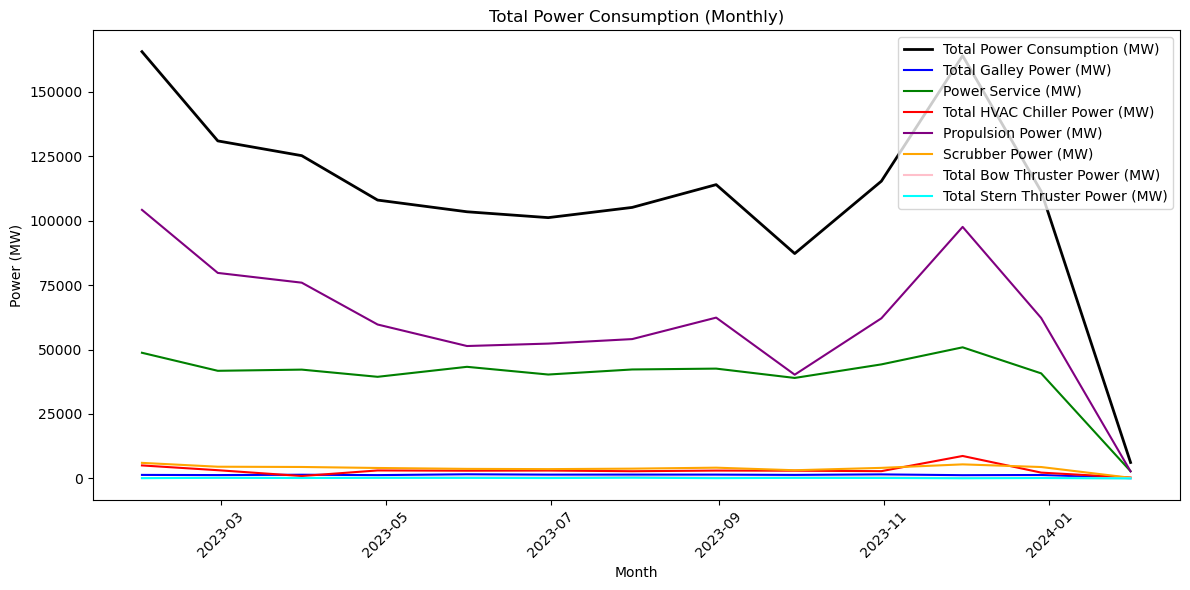

In [12]:
df1['Start Time'] = pd.to_datetime(df1['Start Time'], errors='coerce')

df1['Total Galley Power (MW)'] = df1[['Power Galley 1 (MW)', 'Power Galley 2 (MW)']].sum(axis=1)
df1['Total HVAC Chiller Power (MW)'] = df1[['HVAC Chiller 1 Power (MW)', 'HVAC Chiller 2 Power (MW)', 'HVAC Chiller 3 Power (MW)']].sum(axis=1)
df1['Total Bow Thruster Power (MW)'] = df1[['Bow Thruster 1 Power (MW)', 'Bow Thruster 2 Power (MW)', 'Bow Thruster 3 Power (MW)']].sum(axis=1)
df1['Total Stern Thruster Power (MW)'] = df1[['Stern Thruster 1 Power (MW)', 'Stern Thruster 2 Power (MW)']].sum(axis=1)

# Calculate total power consumption
df1['Total Power Consumption (MW)'] = df1['Total Galley Power (MW)'] + \
                                              df1['Power Service (MW)'] + \
                                              df1['Total HVAC Chiller Power (MW)'] + \
                                              df1['Propulsion Power (MW)'] + \
                                              df1['Scrubber Power (MW)'] + \
                                              df1['Total Bow Thruster Power (MW)'] + \
                                              df1['Total Stern Thruster Power (MW)']

# Resample the data to monthly averages
numeric_columns = df1.select_dtypes(include=['float64', 'int64']).columns
df_copy = df1.copy()
df_copy.set_index('Start Time', inplace=True)
df_vessel_1_resampled = df_copy[numeric_columns].resample('bM').sum()  # Resample by month

# Create the plot
plt.figure(figsize=(12, 6))

# Plot Total Power Consumption (sum of all components)
plt.plot(df_vessel_1_resampled.index, df_vessel_1_resampled['Total Power Consumption (MW)'], label='Total Power Consumption (MW)', color='black', linewidth=2)

# Plot each component
plt.plot(df_vessel_1_resampled.index, df_vessel_1_resampled['Total Galley Power (MW)'], label='Total Galley Power (MW)', linestyle='-', color='blue')
plt.plot(df_vessel_1_resampled.index, df_vessel_1_resampled['Power Service (MW)'], label='Power Service (MW)', linestyle='-', color='green')
plt.plot(df_vessel_1_resampled.index, df_vessel_1_resampled['Total HVAC Chiller Power (MW)'], label='Total HVAC Chiller Power (MW)', linestyle='-', color='red')
plt.plot(df_vessel_1_resampled.index, df_vessel_1_resampled['Propulsion Power (MW)'], label='Propulsion Power (MW)', linestyle='-', color='purple')
plt.plot(df_vessel_1_resampled.index, df_vessel_1_resampled['Scrubber Power (MW)'], label='Scrubber Power (MW)', linestyle='-', color='orange')
plt.plot(df_vessel_1_resampled.index, df_vessel_1_resampled['Total Bow Thruster Power (MW)'], label='Total Bow Thruster Power (MW)', linestyle='-', color='pink')
plt.plot(df_vessel_1_resampled.index, df_vessel_1_resampled['Total Stern Thruster Power (MW)'], label='Total Stern Thruster Power (MW)', linestyle='-', color='cyan')

plt.xlabel('Month')
plt.ylabel('Power (MW)')
plt.title('Total Power Consumption (Monthly)')
plt.legend()

plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()
plt.show()


Insights:

1. The graph shows that **total power consumption** closely follows the trends in **propulsion power**, indicating that propulsion is the primary contributor to overall energy usage.

2. Other components, such as **Power Service** and **Galley Power**, remain relatively stable and contribute consistently but at lower levels.

3. **Bow Thruster**, **Stern Thruster**, and **Scrubber Power** have minimal impact on the total power.

4. The peak in **November** is mainly driven by an increase in propulsion power. Overall, **propulsion power** dominates energy consumption patterns across the months.

HVAC Chiller Power Consumption

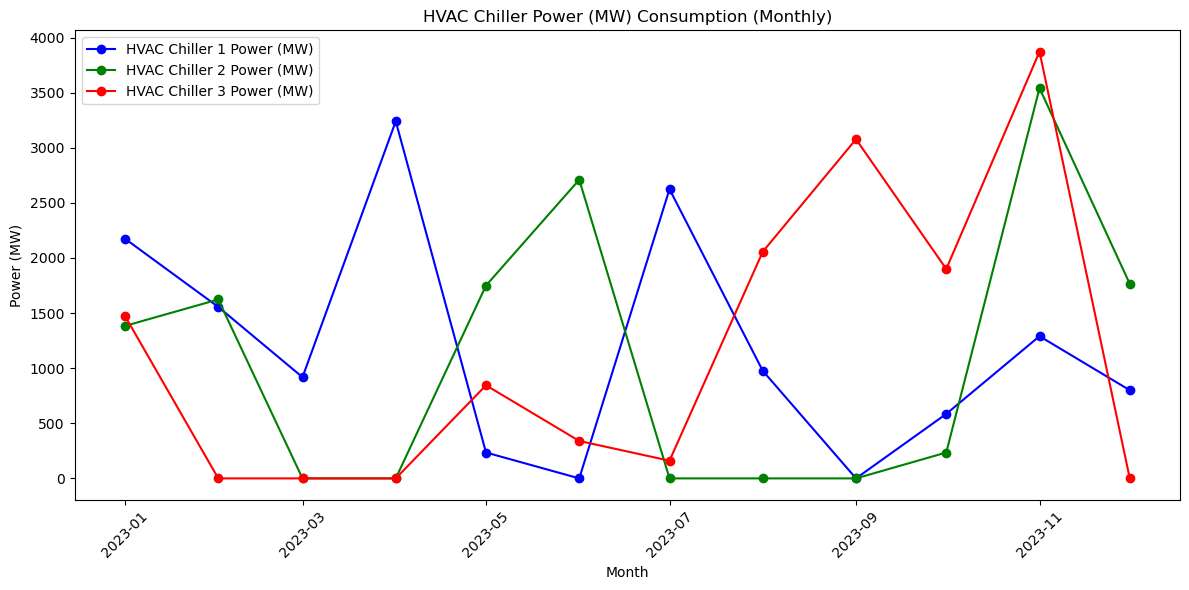

In [13]:
# Extract year and month from 'Start Time' for grouping
df1['Year-Month'] = df1['Start Time'].dt.to_period('M')

# Group by month and calculate the average HVAC Chiller 1, 2, and 3 Power for each month
monthly_hvac_1 = df1.groupby('Year-Month')['HVAC Chiller 1 Power (MW)'].sum()
monthly_hvac_2 = df1.groupby('Year-Month')['HVAC Chiller 2 Power (MW)'].sum()
monthly_hvac_3 = df1.groupby('Year-Month')['HVAC Chiller 3 Power (MW)'].sum()

# Plot multiple lines for HVAC Chiller 1, 2, and 3 Power (MW) on a monthly basis
plt.figure(figsize=(12, 6))

# Plot HVAC Chiller 1 Power
plt.plot(monthly_hvac_1.index.to_timestamp(), monthly_hvac_1, label='HVAC Chiller 1 Power (MW)', color='blue', marker='o')

# Plot HVAC Chiller 2 Power
plt.plot(monthly_hvac_2.index.to_timestamp(), monthly_hvac_2, label='HVAC Chiller 2 Power (MW)', color='green', marker='o')

# Plot HVAC Chiller 3 Power
plt.plot(monthly_hvac_3.index.to_timestamp(), monthly_hvac_3, label='HVAC Chiller 3 Power (MW)', color='red', marker='o')

plt.xlabel('Month')
plt.ylabel('Power (MW)')
plt.title('HVAC Chiller Power (MW) Consumption (Monthly)')

plt.xticks(rotation=45)

plt.legend()

plt.tight_layout()
plt.show()

Insights:

1. The graph shows an **alternating operational pattern** between **HVAC Chiller 1, 2, and 3**, where one chiller tends to consume power while the others remain less active.
2. **Chiller 2 and Chiller 3** demonstrate peak power consumption in **November**, indicating a significant increase in cooling demand during that period.
3. The variability in power consumption across months suggests that the chillers are dynamically adjusted based on **cooling requirements**.
4. The data implies that the system may be designed to **balance load** across the chillers, preventing simultaneous high consumption. This operational strategy could optimize energy usage by selectively activating chillers as needed.

Power Galley 1 and 2 Power Consumption

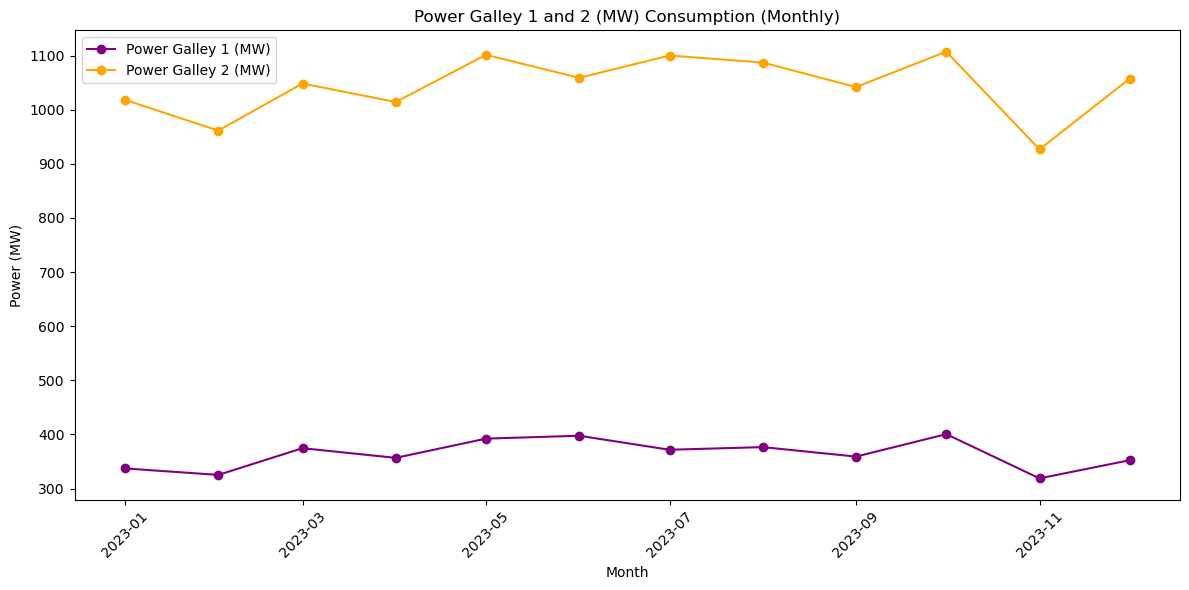

In [14]:
# Group by month and calculate the average Power Galley 1 and 2 for each month
monthly_galley_1 = df1.groupby('Year-Month')['Power Galley 1 (MW)'].sum()
monthly_galley_2 = df1.groupby('Year-Month')['Power Galley 2 (MW)'].sum()

# Plot multiple lines for Power Galley 1 and 2 (MW) on a monthly basis
plt.figure(figsize=(12, 6))

# Plot Power Galley 1
plt.plot(monthly_galley_1.index.to_timestamp(), monthly_galley_1, label='Power Galley 1 (MW)', color='purple', marker='o')

# Plot Power Galley 2
plt.plot(monthly_galley_2.index.to_timestamp(), monthly_galley_2, label='Power Galley 2 (MW)', color='orange', marker='o')

# Add labels and title
plt.xlabel('Month')
plt.ylabel('Power (MW)')
plt.title('Power Galley 1 and 2 (MW) Consumption (Monthly)')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Show legend
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()


Insights:

1. Power Galley 1 remains relatively stable throughout the year, with minor fluctuations between 300 MW and 400 MW.
2. Power Galley 2 consistently operates at higher power levels compared to Power Galley 1, averaging around 1000 MW to 1100 MW.
3. Power consumption for Power Galley 2 increases slightly around mid-year (June-August) but decreases towards the end of the year.
4. There is no significant rise or fall in Power Galley 1, indicating it is less variable and more consistent in power consumption compared to Power Galley 2.
The higher and more variable power consumption in Power Galley 2 indicates that it handles more of the operational load, with peaks during certain months.

Total Power Consumption vs Speed Through Water

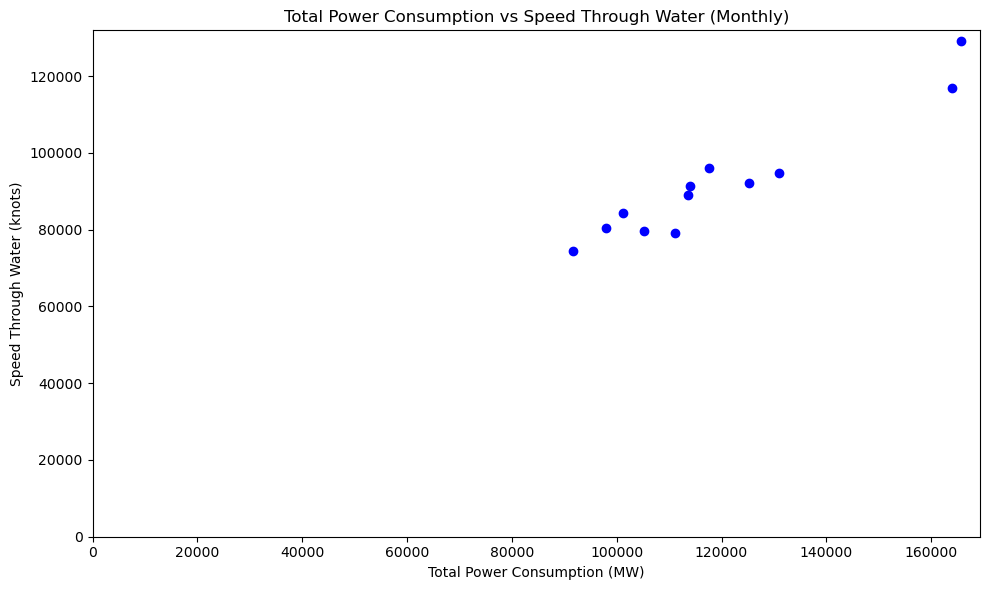

In [15]:
# Group the data by month to aggregate the total power consumption and speed through water for each month
df1['Month'] = df1['Start Time'].dt.to_period('M')

# Calculate the total power consumption components for Vessel 1
df1['Total Galley Power (MW)'] = df1[['Power Galley 1 (MW)', 'Power Galley 2 (MW)']].sum(axis=1)
df1['Total HVAC Chiller Power (MW)'] = df1[['HVAC Chiller 1 Power (MW)', 'HVAC Chiller 2 Power (MW)', 'HVAC Chiller 3 Power (MW)']].sum(axis=1)
df1['Total Bow Thruster Power (MW)'] = df1[['Bow Thruster 1 Power (MW)', 'Bow Thruster 2 Power (MW)', 'Bow Thruster 3 Power (MW)']].sum(axis=1)
df1['Total Stern Thruster Power (MW)'] = df1[['Stern Thruster 1 Power (MW)', 'Stern Thruster 2 Power (MW)']].sum(axis=1)

# Calculate total power consumption
df1['Total Power Consumption (MW)'] = df1['Total Galley Power (MW)'] + \
                                              df1['Power Service (MW)'] + \
                                              df1['Total HVAC Chiller Power (MW)'] + \
                                              df1['Propulsion Power (MW)'] + \
                                              df1['Scrubber Power (MW)'] + \
                                              df1['Total Bow Thruster Power (MW)'] + \
                                              df1['Total Stern Thruster Power (MW)']

# Group the data by month to aggregate the total power consumption and speed through water for each month
monthly_data = df1.groupby('Month').agg({
    'Total Power Consumption (MW)': 'sum',
    'Speed Through Water (knots)': 'sum'  # Assuming you want the average speed through water
}).reset_index()

# Create a scatter plot
plt.figure(figsize=(10, 6))

# Scatter plot of Total Power Consumption vs Speed Through Water
plt.scatter(monthly_data['Total Power Consumption (MW)'], monthly_data['Speed Through Water (knots)'], color='blue')

# Set x-axis and y-axis to start at 0
plt.xlim(0, None)  
plt.ylim(0, None)  

# Add labels and title
plt.xlabel('Total Power Consumption (MW)')
plt.ylabel('Speed Through Water (knots)')
plt.title('Total Power Consumption vs Speed Through Water (Monthly)')

# Show the plot
plt.tight_layout()
plt.show()


Insights:

The graph illustrates a positive correlation between Total Power Consumption and Speed Through Water. As the vessel's speed increases, the power consumption rises accordingly, suggesting that propulsion power is the primary factor driving total energy usage.

Sea Temperature vs Total Power Consumption

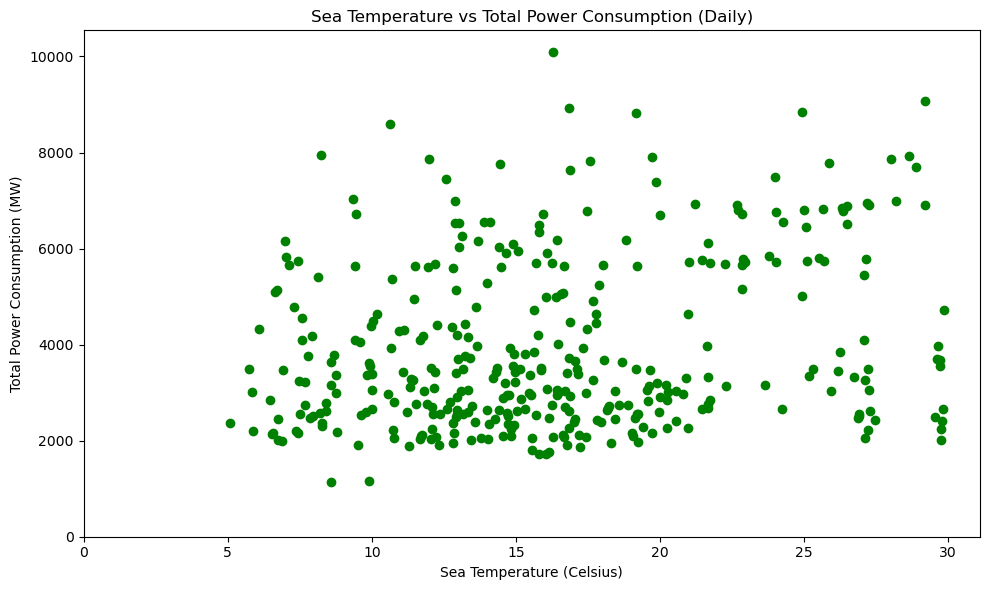

In [16]:
# Calculate the total power consumption components for Vessel 1
df1['Total Galley Power (MW)'] = df1[['Power Galley 1 (MW)', 'Power Galley 2 (MW)']].sum(axis=1)
df1['Total HVAC Chiller Power (MW)'] = df1[['HVAC Chiller 1 Power (MW)', 'HVAC Chiller 2 Power (MW)', 'HVAC Chiller 3 Power (MW)']].sum(axis=1)
df1['Total Bow Thruster Power (MW)'] = df1[['Bow Thruster 1 Power (MW)', 'Bow Thruster 2 Power (MW)', 'Bow Thruster 3 Power (MW)']].sum(axis=1)
df1['Total Stern Thruster Power (MW)'] = df1[['Stern Thruster 1 Power (MW)', 'Stern Thruster 2 Power (MW)']].sum(axis=1)

# Calculate total power consumption
df1['Total Power Consumption (MW)'] = df1['Total Galley Power (MW)'] + \
                                              df1['Power Service (MW)'] + \
                                              df1['Total HVAC Chiller Power (MW)'] + \
                                              df1['Propulsion Power (MW)'] + \
                                              df1['Scrubber Power (MW)'] + \
                                              df1['Total Bow Thruster Power (MW)'] + \
                                              df1['Total Stern Thruster Power (MW)']

# Convert 'Start Time' to day format for details
df1['Start Day'] = df1['Start Time'].dt.to_period('D')

# Group by day to aggregate total power consumption and average sea temperature
daily_data = df1.groupby('Start Day').agg({
    'Total Power Consumption (MW)': 'sum',
    'Sea Temperature (Celsius)': 'mean' 
}).reset_index()

# Create a scatter plot
plt.figure(figsize=(10, 6))

# Scatter plot of Sea Temperature vs Total Power Consumption
plt.scatter(daily_data['Sea Temperature (Celsius)'], daily_data['Total Power Consumption (MW)'], color='green')

# Set x-axis and y-axis to start at 0
plt.xlim(0, None) 
plt.ylim(0, None) 

# Add labels and title
plt.xlabel('Sea Temperature (Celsius)')
plt.ylabel('Total Power Consumption (MW)')
plt.title('Sea Temperature vs Total Power Consumption (Daily)')

# Show the plot
plt.tight_layout()
plt.show()


Insights:

There is no significant correlation between sea temperature and total power consumption in this dataset.

Sea Temperature vs Total HVAC Chiller Power

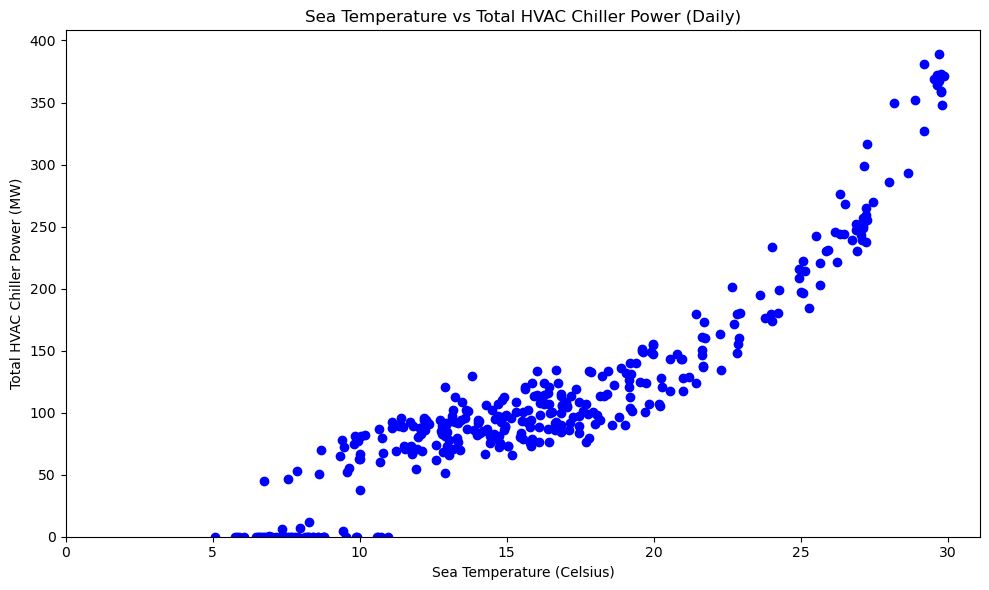

In [17]:
# Calculate the total HVAC chiller power consumption components for Vessel 1
df1['Total HVAC Chiller Power (MW)'] = df1[['HVAC Chiller 1 Power (MW)', 'HVAC Chiller 2 Power (MW)', 'HVAC Chiller 3 Power (MW)']].sum(axis=1)

# Convert 'Start Time' to day format for details
df1['Start Day'] = df1['Start Time'].dt.to_period('D')

# Group by day to aggregate HVAC chiller power consumption and average sea temperature
daily_data_hvac = df1.groupby('Start Day').agg({
    'Total HVAC Chiller Power (MW)': 'sum',
    'Sea Temperature (Celsius)': 'mean'  # Average sea temperature for the day
}).reset_index()

# Create a scatter plot
plt.figure(figsize=(10, 6))

# Scatter plot of Sea Temperature vs Average Total HVAC Power
plt.scatter(daily_data_hvac['Sea Temperature (Celsius)'], daily_data_hvac['Total HVAC Chiller Power (MW)'], color='blue')


plt.xlim(0, None) 
plt.ylim(0, None) 

# Add labels and title
plt.xlabel('Sea Temperature (Celsius)')
plt.ylabel('Total HVAC Chiller Power (MW)')
plt.title('Sea Temperature vs Total HVAC Chiller Power (Daily)')

# Show the plot
plt.tight_layout()
plt.show()


Insights:

1. Strong Positive Correlation: The scatter plot reveals a clear linear relationship between sea temperature and HVAC power consumption, where an increase in sea temperature results in a proportional increase in HVAC energy demand.
2. Exponential Increase Above 20°C: There is a notable spike in HVAC consumption beyond 20°C sea temperature, indicating a substantial rise in cooling requirements as the external environment becomes warmer.
3. Stable Power Consumption Below 15°C: The HVAC system consumes relatively low and stable power when the sea temperature is below 15°C, reflecting minimal cooling needs in cooler environments.

Analysis OF Power Generation

Stationary Vs Moving Diesel Generator

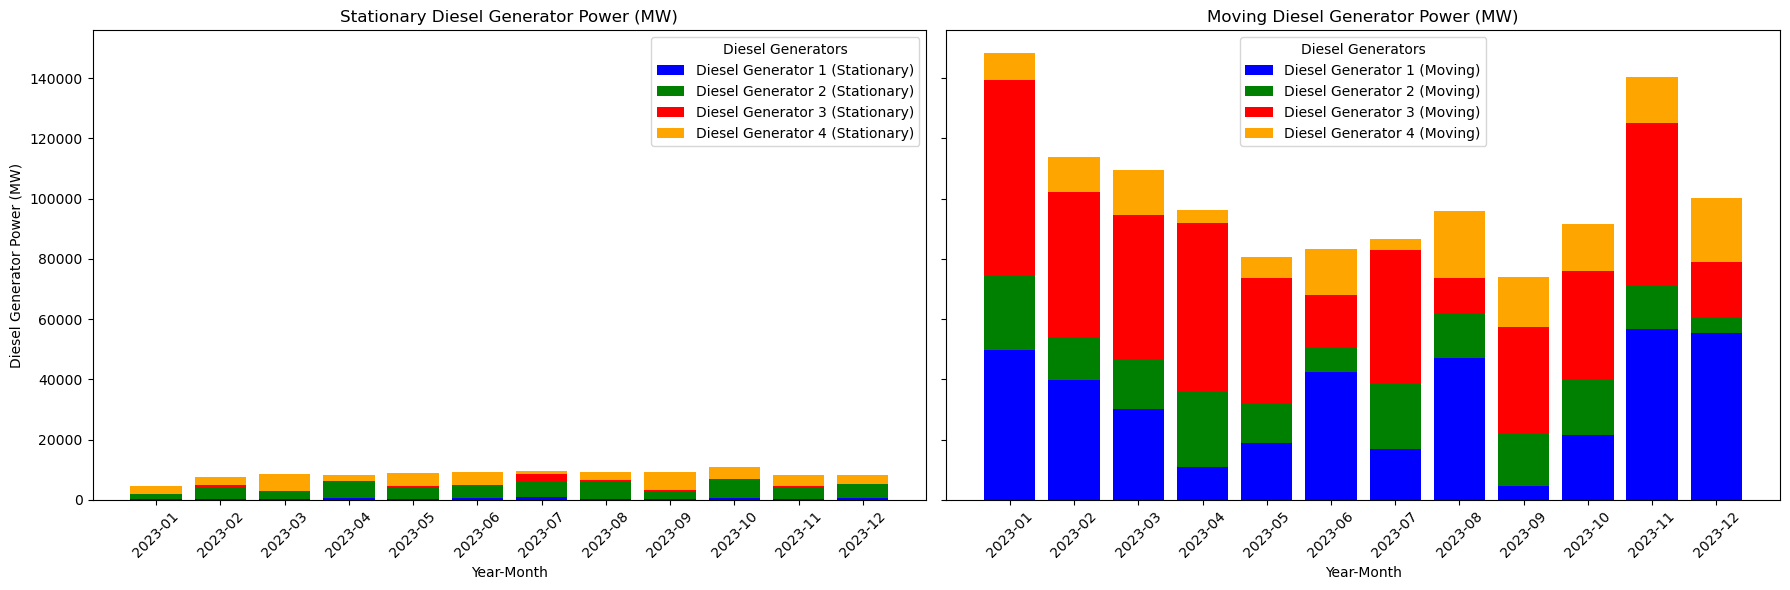

In [18]:
df1['Start Time'] = pd.to_datetime(df1['Start Time'], errors='coerce')

# Drop rows where 'Start Time' couldn't be converted
# df1 = df1.dropna(subset=['Start Time'])

# Extract Year-Month for grouping
df1['Year-Month'] = df1['Start Time'].dt.to_period('M')

# Create the "Stationary vs. Non-Stationary" calculated field
df1['Stationary vs Non-Stationary'] = df1['Speed Through Water (knots)'].apply(lambda x: 'Moving' if x > 0.1 else 'Stationary')

# Group by Year-Month and 'Stationary vs Non-Stationary', and calculate sum of Diesel Generators 1-4
grouped_data = df1.groupby(['Year-Month', 'Stationary vs Non-Stationary'])[['Diesel Generator 1 Power (MW)', 
                                                                             'Diesel Generator 2 Power (MW)', 
                                                                             'Diesel Generator 3 Power (MW)', 
                                                                             'Diesel Generator 4 Power (MW)']].sum()

# Unstack the 'Stationary vs Non-Stationary' to prepare data for bar plot
unstacked_data = grouped_data.unstack(level=-1)

# Select the "Stationary" and "Moving" data for the graph
stationary_data = unstacked_data.xs('Stationary', level='Stationary vs Non-Stationary', axis=1)
moving_data = unstacked_data.xs('Moving', level='Stationary vs Non-Stationary', axis=1)

# Create the side-by-side plot (2 subplots)
fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

# Define positions for the bars
positions = np.arange(len(stationary_data))

# Plot for Stationary
axes[0].bar(positions, stationary_data['Diesel Generator 1 Power (MW)'], label='Diesel Generator 1 (Stationary)', color='blue')
axes[0].bar(positions, stationary_data['Diesel Generator 2 Power (MW)'], bottom=stationary_data['Diesel Generator 1 Power (MW)'], label='Diesel Generator 2 (Stationary)', color='green')
axes[0].bar(positions, stationary_data['Diesel Generator 3 Power (MW)'], bottom=stationary_data['Diesel Generator 1 Power (MW)'] + stationary_data['Diesel Generator 2 Power (MW)'], label='Diesel Generator 3 (Stationary)', color='red')
axes[0].bar(positions, stationary_data['Diesel Generator 4 Power (MW)'], bottom=stationary_data['Diesel Generator 1 Power (MW)'] + stationary_data['Diesel Generator 2 Power (MW)'] + stationary_data['Diesel Generator 3 Power (MW)'], label='Diesel Generator 4 (Stationary)', color='orange')

axes[0].set_title('Stationary Diesel Generator Power (MW)')
axes[0].set_xlabel('Year-Month')
axes[0].set_ylabel('Diesel Generator Power (MW)')
axes[0].set_xticks(positions)
axes[0].set_xticklabels(stationary_data.index, rotation=45)
axes[0].legend(title='Diesel Generators')

# Plot for Moving
axes[1].bar(positions, moving_data['Diesel Generator 1 Power (MW)'], label='Diesel Generator 1 (Moving)', color='blue')
axes[1].bar(positions, moving_data['Diesel Generator 2 Power (MW)'], bottom=moving_data['Diesel Generator 1 Power (MW)'], label='Diesel Generator 2 (Moving)', color='green')
axes[1].bar(positions, moving_data['Diesel Generator 3 Power (MW)'], bottom=moving_data['Diesel Generator 1 Power (MW)'] + moving_data['Diesel Generator 2 Power (MW)'], label='Diesel Generator 3 (Moving)', color='red')
axes[1].bar(positions, moving_data['Diesel Generator 4 Power (MW)'], bottom=moving_data['Diesel Generator 1 Power (MW)'] + moving_data['Diesel Generator 2 Power (MW)'] + moving_data['Diesel Generator 3 Power (MW)'], label='Diesel Generator 4 (Moving)', color='orange')

axes[1].set_title('Moving Diesel Generator Power (MW)')
axes[1].set_xlabel('Year-Month')
axes[1].set_xticks(positions)
axes[1].set_xticklabels(moving_data.index, rotation=45)
axes[1].legend(title='Diesel Generators')

# Tight layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()


Insights:

1. In the stationary state, Diesel Generator 2 and Diesel Generator 4 are primarily responsible for power generation, with minimal contribution from Diesel Generator 1 and 3.
2. The power usage remains consistently low while the vessel is stationary, indicating that fewer generators are needed to meet the energy demands.
3. During movement, all four diesel generators are actively contributing to power generation, with Diesel Generator 1 and 3 providing the highest output.
4. The power consumption spikes significantly when the vessel is moving, especially in January and November, showing higher energy demands during these months.
5. The difference in generator usage between stationary and moving states highlights the dynamic operational needs based on the vessel's activity.

Analysis of Fuel Efficiency

Monthly Fuel Efficiency and Sea Temperature

In [19]:
# Ensure 'Start Time' is in datetime format
df1['Start Time'] = pd.to_datetime(df1['Start Time'], errors='coerce')

# Extract Year-Month for grouping
df1['Month'] = df1['Start Time'].dt.month_name(locale='English')

# Calculate total power generated (sum of Diesel Generators 1, 2, 3, 4)
df1['Total Power Generated (MW)'] = df1[['Diesel Generator 1 Power (MW)', 
                                         'Diesel Generator 2 Power (MW)', 
                                         'Diesel Generator 3 Power (MW)', 
                                         'Diesel Generator 4 Power (MW)']].sum(axis=1)

# Calculate total fuel rate (sum of Boiler 1, 2, Incinerator, Main Engine 1, 2, 3, 4)
df1['Total Fuel Rate'] = df1[['Boiler 1 Fuel Flow Rate (L/h)', 'Boiler 2 Fuel Flow Rate (L/h)', 
                              'Incinerator 1 Fuel Flow Rate (L/h)', 
                              'Main Engine 1 Fuel Flow Rate (kg/h)', 'Main Engine 2 Fuel Flow Rate (kg/h)', 
                              'Main Engine 3 Fuel Flow Rate (kg/h)', 'Main Engine 4 Fuel Flow Rate (kg/h)']].sum(axis=1)

# Calculate fuel efficiency = (Total Power Generated) / (Total Fuel Rate)
df1['Fuel Efficiency'] = df1['Total Fuel Rate']/df1['Total Power Generated (MW)']
# Group by Year-Month and calculate the monthly average fuel efficiency and sea temperature
monthly_data = df1.groupby('Month').agg({
    'Fuel Efficiency': 'mean',
    'Sea Temperature (Celsius)': 'mean',
    'Speed Over Ground (knots)': 'mean'
}).reset_index()

In [20]:
monthly_data

,Month,Fuel Efficiency,Sea Temperature (Celsius),Speed Over Ground (knots)
0,April,237.690272,16.190652,10.182756
1,August,231.149432,16.135711,10.160860
2,December,236.657205,14.066861,10.644465
3,February,230.947596,17.095354,11.373996
4,January,224.366959,21.738152,13.974015
5,July,231.190155,15.472215,8.913304
6,June,234.272224,14.180246,9.684154
7,March,243.914652,9.478046,10.359567
8,May,236.022786,12.506934,9.028322
9,November,218.920668,26.791428,12.858760


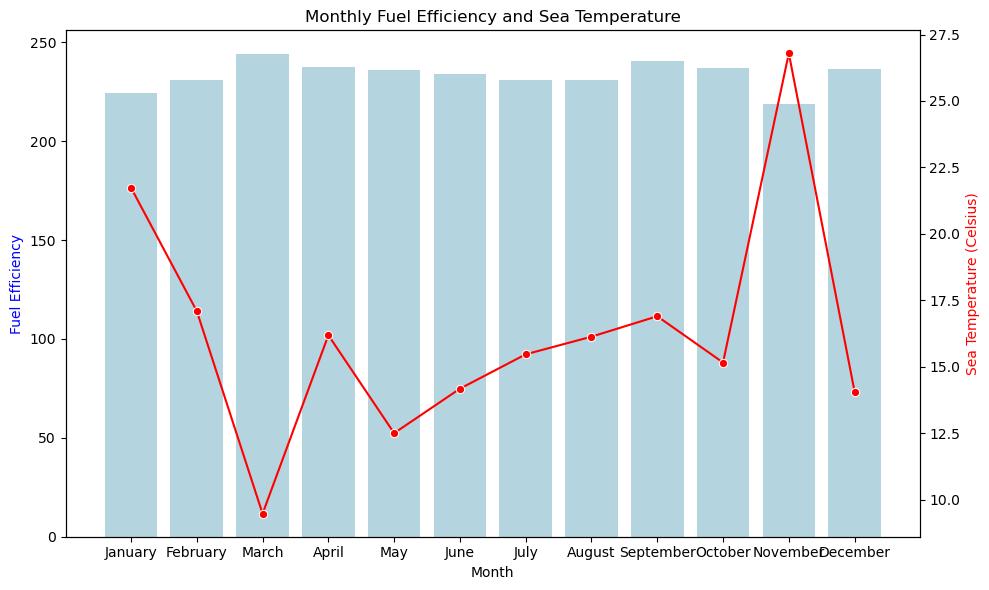

In [21]:

month_order = ['January', 'February', 'March', 'April', 'May', 'June', 
               'July', 'August', 'September', 'October', 'November', 'December']

# Convert the 'Month' column to a categorical type with the specified order
monthly_data['Month'] = pd.Categorical(monthly_data['Month'], categories=month_order, ordered=True)

# Create the figure and axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar plot for Fuel Efficiency
sns.barplot(x='Month', y='Fuel Efficiency', data=monthly_data, ax=ax1, color='lightblue')

# Create another axis for Sea Temperature
ax2 = ax1.twinx()

# Line plot for Sea Temperature (Celsius)
sns.lineplot(x='Month', y='Sea Temperature (Celsius)', data=monthly_data, ax=ax2, color='red', marker='o')

# Set labels
ax1.set_xlabel('Month')
ax1.set_ylabel('Fuel Efficiency', color='blue')
ax2.set_ylabel('Sea Temperature (Celsius)', color='red')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Set title
plt.title('Monthly Fuel Efficiency and Sea Temperature')

# Show plot
plt.tight_layout()
plt.show()


Monthly Fuel Efficiency and Speed Over Ground

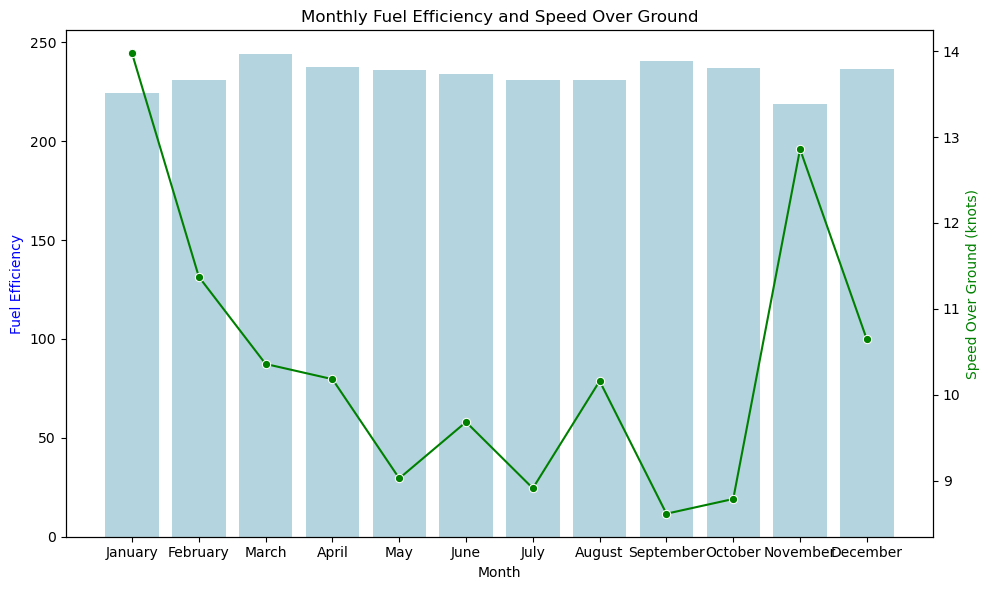

In [22]:

month_order = ['January', 'February', 'March', 'April', 'May', 'June', 
               'July', 'August', 'September', 'October', 'November', 'December']

# Convert the 'Month' column to a categorical type with the specified order
monthly_data['Month'] = pd.Categorical(monthly_data['Month'], categories=month_order, ordered=True)

# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar plot for Fuel Efficiency
sns.barplot(x='Month', y='Fuel Efficiency', data=monthly_data, ax=ax1, color='lightblue')

# Create another axis for Speed Over Ground
ax2 = ax1.twinx()

# Line plot for Speed Over Ground (knots)
sns.lineplot(x='Month', y='Speed Over Ground (knots)', data=monthly_data, ax=ax2, color='green', marker='o')

# Set labels
ax1.set_xlabel('Month')
ax1.set_ylabel('Fuel Efficiency', color='blue')
ax2.set_ylabel('Speed Over Ground (knots)', color='green')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Set title
plt.title('Monthly Fuel Efficiency and Speed Over Ground')

# Show plot
plt.tight_layout()
plt.show()


Analysis For vessel 2

Data Cleaning

In [23]:
df2.isnull().sum()

Start Time                                  0
End Time                                    0
Vessel Name                                 0
Power Galley 1 (MW)                        15
Power Galley 2 (MW)                        15
Power Service (MW)                         17
HVAC Chiller 1 Power (MW)                 206
HVAC Chiller 2 Power (MW)                 206
HVAC Chiller 3 Power (MW)                 206
Scrubber Power (MW)                        15
Sea Temperature (Celsius)                  15
Boiler 1 Fuel Flow Rate (L/h)              15
Boiler 2 Fuel Flow Rate (L/h)              15
Incinerator 1 Fuel Flow Rate (L/h)         15
Diesel Generator 1 Power (MW)              15
Diesel Generator 2 Power (MW)              15
Diesel Generator 3 Power (MW)              15
Diesel Generator 4 Power (MW)              15
Latitude (Degrees)                        340
Longitude (Degrees)                       340
Relative Wind Angle (Degrees)              14
True Wind Angle (Degrees)         

Fixing Null Values

In [24]:
df2 = df2.dropna(subset=['Scrubber Power (MW)'])
df2 = df2.dropna(subset=['Speed Through Water (knots)'])

Analysis OF Power Generation

Monthly Power Consumption

C:\Users\Keertisuryawanshi\AppData\Local\Temp\ipykernel_24560\3060691168.py:26: FutureWarning: 'bM' is deprecated and will be removed in a future version, please use 'BME' instead.
  df_vessel_1_resampled = df_copy_1[numeric_columns].resample('bM').sum()  # Resample by month


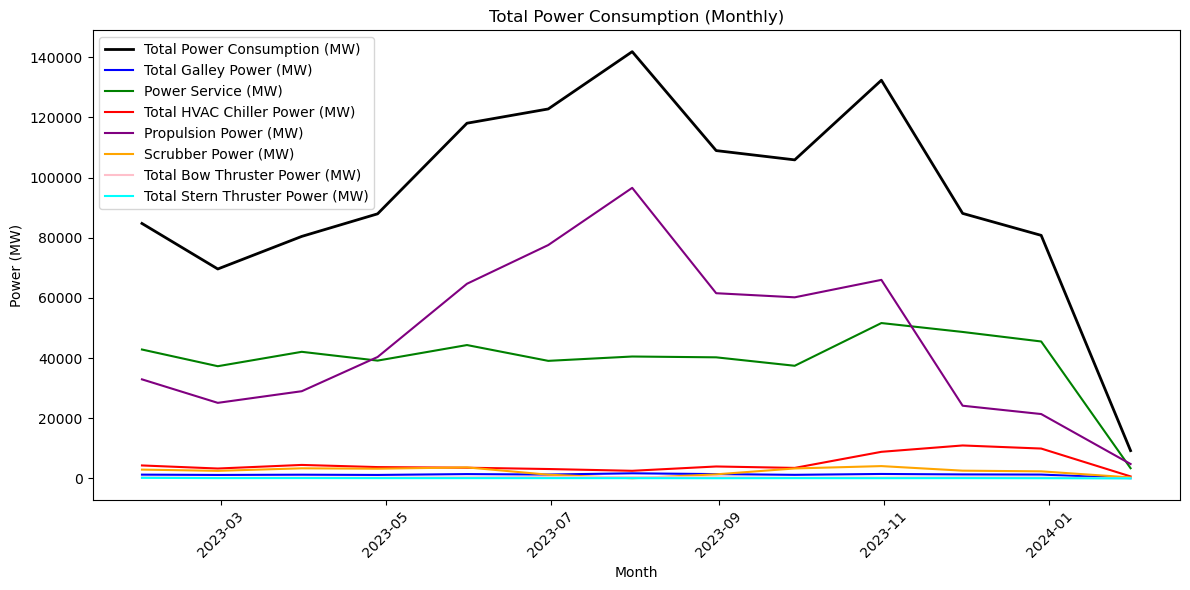

In [25]:

# Ensure 'Start Time' is in datetime format
df2['Start Time'] = pd.to_datetime(df2['Start Time'], errors='coerce')

# Set 'Start Time' as the index for resampling
# df2.set_index('Start Time', inplace=True)

# Calculate the total power consumption components for Vessel 2
df2['Total Galley Power (MW)'] = df2[['Power Galley 1 (MW)', 'Power Galley 2 (MW)']].sum(axis=1)
df2['Total HVAC Chiller Power (MW)'] = df2[['HVAC Chiller 1 Power (MW)', 'HVAC Chiller 2 Power (MW)', 'HVAC Chiller 3 Power (MW)']].sum(axis=1)
df2['Total Bow Thruster Power (MW)'] = df2[['Bow Thruster 1 Power (MW)', 'Bow Thruster 2 Power (MW)', 'Bow Thruster 3 Power (MW)']].sum(axis=1)
df2['Total Stern Thruster Power (MW)'] = df2[['Stern Thruster 1 Power (MW)', 'Stern Thruster 2 Power (MW)']].sum(axis=1)

# Calculate total power consumption
df2['Total Power Consumption (MW)'] = df2['Total Galley Power (MW)'] + \
                                              df2['Power Service (MW)'] + \
                                              df2['Total HVAC Chiller Power (MW)'] + \
                                              df2['Propulsion Power (MW)'] + \
                                              df2['Scrubber Power (MW)'] + \
                                              df2['Total Bow Thruster Power (MW)'] + \
                                              df2['Total Stern Thruster Power (MW)']

# Resample the data to monthly averages
numeric_columns = df2.select_dtypes(include=['float64', 'int64']).columns
df_copy_1 = df2.copy()
df_copy_1.set_index('Start Time', inplace=True)
df_vessel_1_resampled = df_copy_1[numeric_columns].resample('bM').sum()  # Resample by month

# Create the plot
plt.figure(figsize=(12, 6))

# Plot Total Power Consumption (sum of all components)
plt.plot(df_vessel_1_resampled.index, df_vessel_1_resampled['Total Power Consumption (MW)'], label='Total Power Consumption (MW)', color='black', linewidth=2)

# Plot each component
plt.plot(df_vessel_1_resampled.index, df_vessel_1_resampled['Total Galley Power (MW)'], label='Total Galley Power (MW)', linestyle='-', color='blue')
plt.plot(df_vessel_1_resampled.index, df_vessel_1_resampled['Power Service (MW)'], label='Power Service (MW)', linestyle='-', color='green')
plt.plot(df_vessel_1_resampled.index, df_vessel_1_resampled['Total HVAC Chiller Power (MW)'], label='Total HVAC Chiller Power (MW)', linestyle='-', color='red')
plt.plot(df_vessel_1_resampled.index, df_vessel_1_resampled['Propulsion Power (MW)'], label='Propulsion Power (MW)', linestyle='-', color='purple')
plt.plot(df_vessel_1_resampled.index, df_vessel_1_resampled['Scrubber Power (MW)'], label='Scrubber Power (MW)', linestyle='-', color='orange')
plt.plot(df_vessel_1_resampled.index, df_vessel_1_resampled['Total Bow Thruster Power (MW)'], label='Total Bow Thruster Power (MW)', linestyle='-', color='pink')
plt.plot(df_vessel_1_resampled.index, df_vessel_1_resampled['Total Stern Thruster Power (MW)'], label='Total Stern Thruster Power (MW)', linestyle='-', color='cyan')

# Add labels and title
plt.xlabel('Month')
plt.ylabel('Power (MW)')
plt.title('Total Power Consumption (Monthly)')
plt.legend()

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()
plt.show()


Insights:

1. The total power consumption (black line) shows a strong upward trend in the latter months, especially toward the end of the year.
2. The propulsion power (purple line) follows a similar pattern, indicating its substantial contribution to the overall power consumption.
3. Power Service (green line) remains relatively stable throughout the months, contributing consistently to the total power. HVAC Chiller Power (red line) and other minor components like Bow Thruster, Stern Thruster, and Scrubber Power have minimal impacts on total power consumption, showing little variation and lower values overall.
4. The peaks in total power are largely driven by increases in propulsion power.

HVAC Chiller Power Consumption

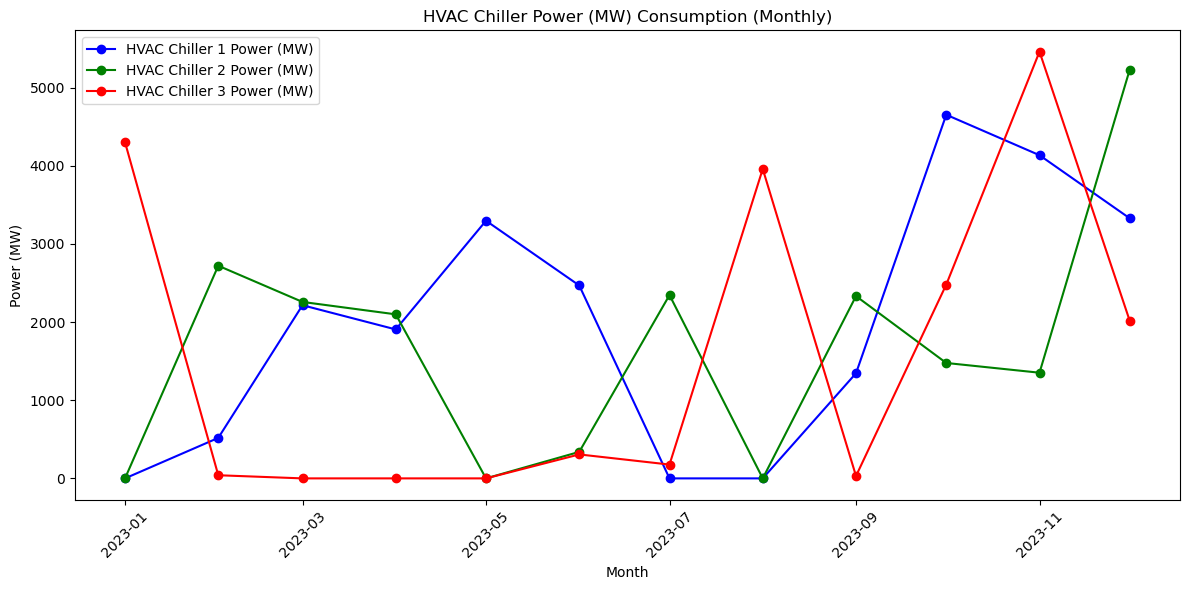

In [26]:
df2['Year-Month'] = df2['Start Time'].dt.to_period('M')

# Group by month and calculate the average HVAC Chiller 1, 2, and 3 Power for each month
monthly_hvac_1 = df2.groupby('Year-Month')['HVAC Chiller 1 Power (MW)'].sum()
monthly_hvac_2 = df2.groupby('Year-Month')['HVAC Chiller 2 Power (MW)'].sum()
monthly_hvac_3 = df2.groupby('Year-Month')['HVAC Chiller 3 Power (MW)'].sum()

# Plot multiple lines for HVAC Chiller 1, 2, and 3 Power (MW) on a monthly basis
plt.figure(figsize=(12, 6))

# Plot HVAC Chiller 1 Power
plt.plot(monthly_hvac_1.index.to_timestamp(), monthly_hvac_1, label='HVAC Chiller 1 Power (MW)', color='blue', marker='o')

# Plot HVAC Chiller 2 Power
plt.plot(monthly_hvac_2.index.to_timestamp(), monthly_hvac_2, label='HVAC Chiller 2 Power (MW)', color='green', marker='o')

# Plot HVAC Chiller 3 Power
plt.plot(monthly_hvac_3.index.to_timestamp(), monthly_hvac_3, label='HVAC Chiller 3 Power (MW)', color='red', marker='o')

# Add labels and title
plt.xlabel('Month')
plt.ylabel('Power (MW)')
plt.title('HVAC Chiller Power (MW) Consumption (Monthly)')

plt.xticks(rotation=45)

plt.legend()

plt.tight_layout()
plt.show()

Insights:

In this graph, the HVAC Chillers 1, 2, and 3 show varying power consumption without a clear, consistent switching pattern between them. The chillers do not alternate predictably but instead fluctuate independently in their power usage. At times, one chiller consumes more power while the others drop to lower levels, suggesting that the chillers operate based on individual demand rather than compensating for each other in a coordinated way.

Power Galley 1 and 2 Power Consumption

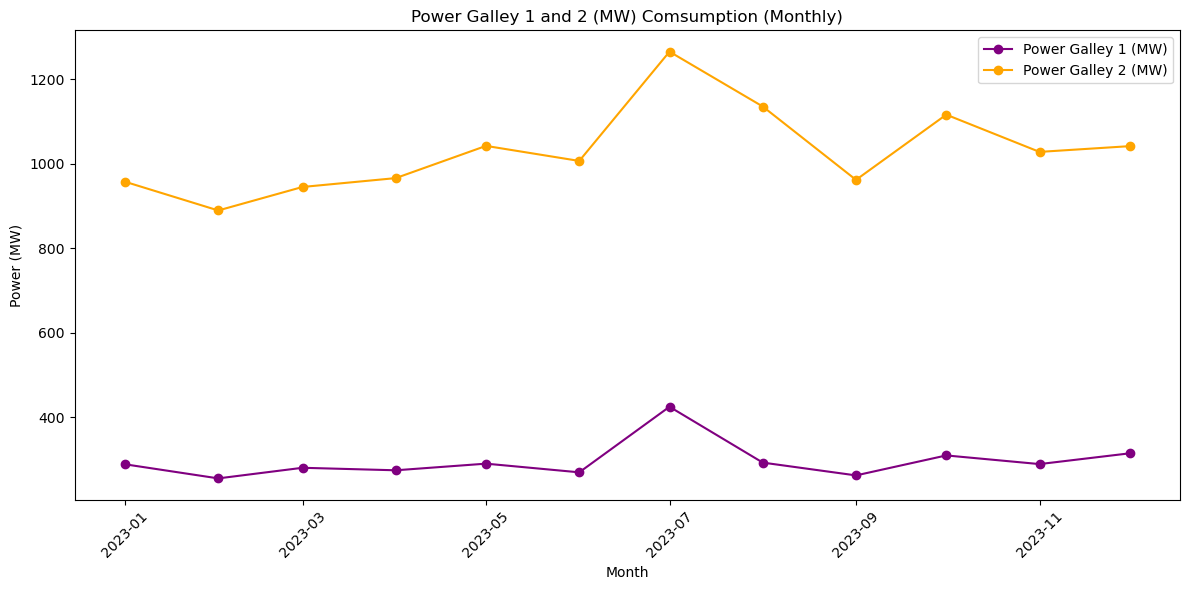

In [27]:
# Group by month and calculate the average Power Galley 1 and 2 for each month
monthly_galley_1 = df2.groupby('Year-Month')['Power Galley 1 (MW)'].sum()
monthly_galley_2 = df2.groupby('Year-Month')['Power Galley 2 (MW)'].sum()

# Plot multiple lines for Power Galley 1 and 2 (MW) on a monthly basis
plt.figure(figsize=(12, 6))

# Plot Power Galley 1
plt.plot(monthly_galley_1.index.to_timestamp(), monthly_galley_1, label='Power Galley 1 (MW)', color='purple', marker='o')

# Plot Power Galley 2
plt.plot(monthly_galley_2.index.to_timestamp(), monthly_galley_2, label='Power Galley 2 (MW)', color='orange', marker='o')

# Add labels and title
plt.xlabel('Month')
plt.ylabel('Power (MW)')
plt.title('Power Galley 1 and 2 (MW) Comsumption (Monthly)')

plt.xticks(rotation=45)

# Show legend
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()


Insights:

1. In this graph, Power Galley 2 consistently shows higher power consumption compared to Power Galley 1 across all months of 2023.
2. While Power Galley 1 remains relatively stable with minor fluctuations throughout the year, Power Galley 2 demonstrates a more pronounced trend, staying above 1000 MW.
3. Power Galley 1 hovers around the 300-400 MW range, showing less variation in power usage. Overall, the graph highlights Power Galley 2 as the primary driver of galley power consumption over time.

Total Power Consumption vs Speed Through Water

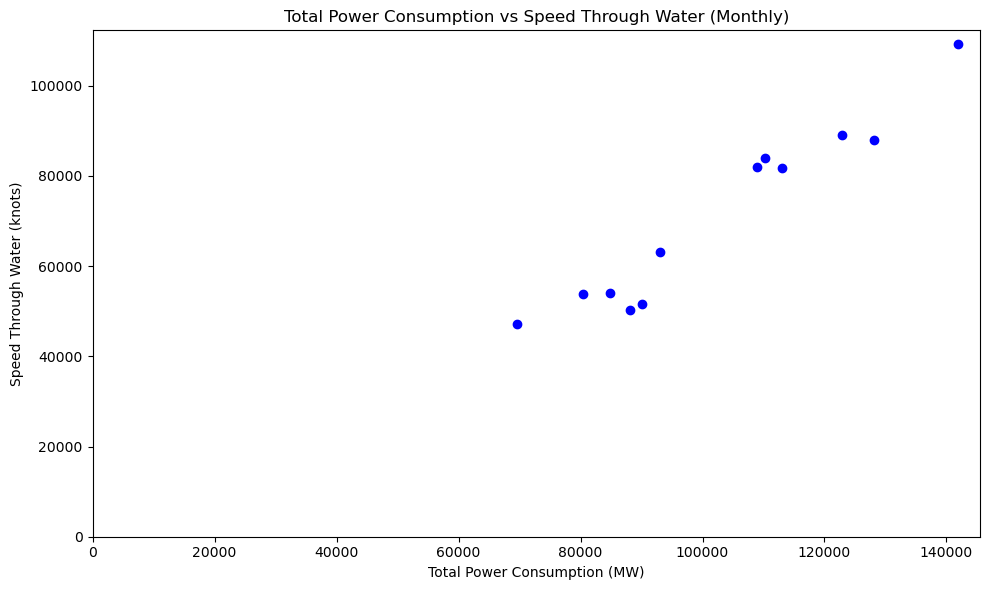

In [28]:
# Group the data by month to aggregate the total power consumption and speed through water for each month
df2['Month'] = df2['Start Time'].dt.to_period('M')

# Calculate the total power consumption components for Vessel 2
df2['Total Galley Power (MW)'] = df2[['Power Galley 1 (MW)', 'Power Galley 2 (MW)']].sum(axis=1)
df2['Total HVAC Chiller Power (MW)'] = df2[['HVAC Chiller 1 Power (MW)', 'HVAC Chiller 2 Power (MW)', 'HVAC Chiller 3 Power (MW)']].sum(axis=1)
df2['Total Bow Thruster Power (MW)'] = df2[['Bow Thruster 1 Power (MW)', 'Bow Thruster 2 Power (MW)', 'Bow Thruster 3 Power (MW)']].sum(axis=1)
df2['Total Stern Thruster Power (MW)'] = df2[['Stern Thruster 1 Power (MW)', 'Stern Thruster 2 Power (MW)']].sum(axis=1)

# Calculate total power consumption
df2['Total Power Consumption (MW)'] = df2['Total Galley Power (MW)'] + \
                                              df2['Power Service (MW)'] + \
                                              df2['Total HVAC Chiller Power (MW)'] + \
                                              df2['Propulsion Power (MW)'] + \
                                              df2['Scrubber Power (MW)'] + \
                                              df2['Total Bow Thruster Power (MW)'] + \
                                              df2['Total Stern Thruster Power (MW)']

# Group the data by month to aggregate the total power consumption and speed through water for each month
monthly_data = df2.groupby('Month').agg({
    'Total Power Consumption (MW)': 'sum',
    'Speed Through Water (knots)': 'sum' 
}).reset_index()

# Create a scatter plot
plt.figure(figsize=(10, 6))

# Scatter plot of Total Power Consumption vs Speed Through Water
plt.scatter(monthly_data['Total Power Consumption (MW)'], monthly_data['Speed Through Water (knots)'], color='blue')


plt.xlim(0, None)  
plt.ylim(0, None) 

plt.xlabel('Total Power Consumption (MW)')
plt.ylabel('Speed Through Water (knots)')
plt.title('Total Power Consumption vs Speed Through Water (Monthly)')

plt.tight_layout()
plt.show()


Insights:

The graph indicates a positive correlation between total power consumption and speed through water. As the vessel's speed increases, there is a corresponding rise in power consumption, reflecting the increased propulsion demand. This trend is consistent across the monthly data, suggesting that higher speeds significantly influence overall power usage on the vessel.

Sea Temperature vs Total Power Consumption

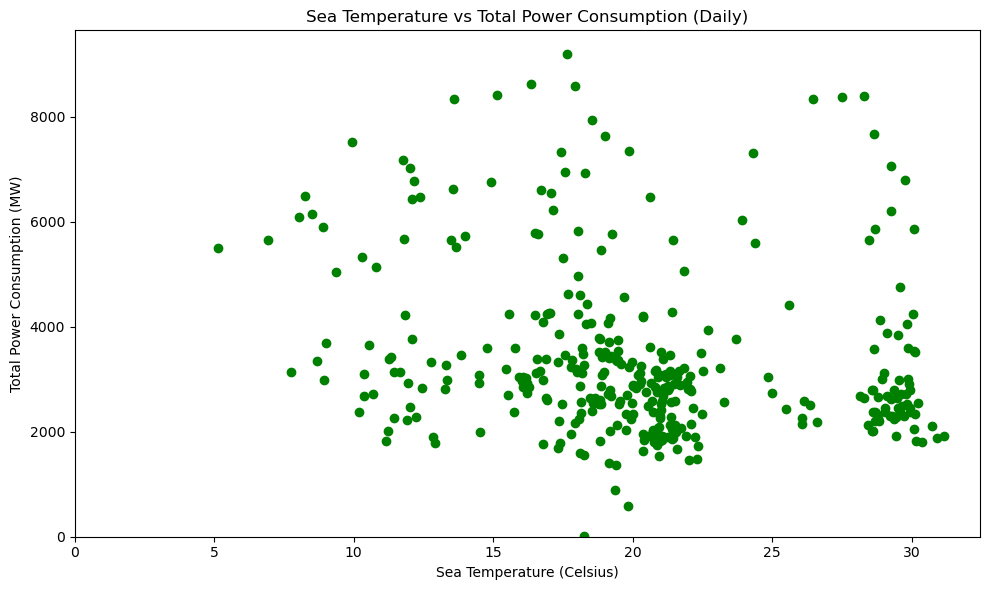

In [29]:
# Calculate the total power consumption components for Vessel 2
df2['Total Galley Power (MW)'] = df2[['Power Galley 1 (MW)', 'Power Galley 2 (MW)']].sum(axis=1)
df2['Total HVAC Chiller Power (MW)'] = df2[['HVAC Chiller 1 Power (MW)', 'HVAC Chiller 2 Power (MW)', 'HVAC Chiller 3 Power (MW)']].sum(axis=1)
df2['Total Bow Thruster Power (MW)'] = df2[['Bow Thruster 1 Power (MW)', 'Bow Thruster 2 Power (MW)', 'Bow Thruster 3 Power (MW)']].sum(axis=1)
df2['Total Stern Thruster Power (MW)'] = df2[['Stern Thruster 1 Power (MW)', 'Stern Thruster 2 Power (MW)']].sum(axis=1)

# Calculate total power consumption
df2['Total Power Consumption (MW)'] = df2['Total Galley Power (MW)'] + \
                                              df2['Power Service (MW)'] + \
                                              df2['Total HVAC Chiller Power (MW)'] + \
                                              df2['Propulsion Power (MW)'] + \
                                              df2['Scrubber Power (MW)'] + \
                                              df2['Total Bow Thruster Power (MW)'] + \
                                              df2['Total Stern Thruster Power (MW)']

# Convert 'Start Time' to day format for details
df2['Start Day'] = df2['Start Time'].dt.to_period('D')

# Group by day to aggregate total power consumption and average sea temperature
daily_data = df2.groupby('Start Day').agg({
    'Total Power Consumption (MW)': 'sum',
    'Sea Temperature (Celsius)': 'mean'  # Assuming you want the average sea temperature
}).reset_index()

# Create a scatter plot
plt.figure(figsize=(10, 6))

# Scatter plot of Sea Temperature vs Total Power Consumption
plt.scatter(daily_data['Sea Temperature (Celsius)'], daily_data['Total Power Consumption (MW)'], color='green')

# Set x-axis and y-axis to start at 0
plt.xlim(0, None)  # X-axis starts at 0
plt.ylim(0, None)  # Y-axis starts at 0

# Add labels and title
plt.xlabel('Sea Temperature (Celsius)')
plt.ylabel('Total Power Consumption (MW)')
plt.title('Sea Temperature vs Total Power Consumption (Daily)')

# Show the plot
plt.tight_layout()
plt.show()


Insights:

The scattered distribution of data points suggests that variations in sea temperature do not exhibit a strong correlation with overall power consumption, indicating that sea temperature is not a primary driver of fluctuations in total energy usage.

Sea Temperature vs Total HVAC Chiller Power

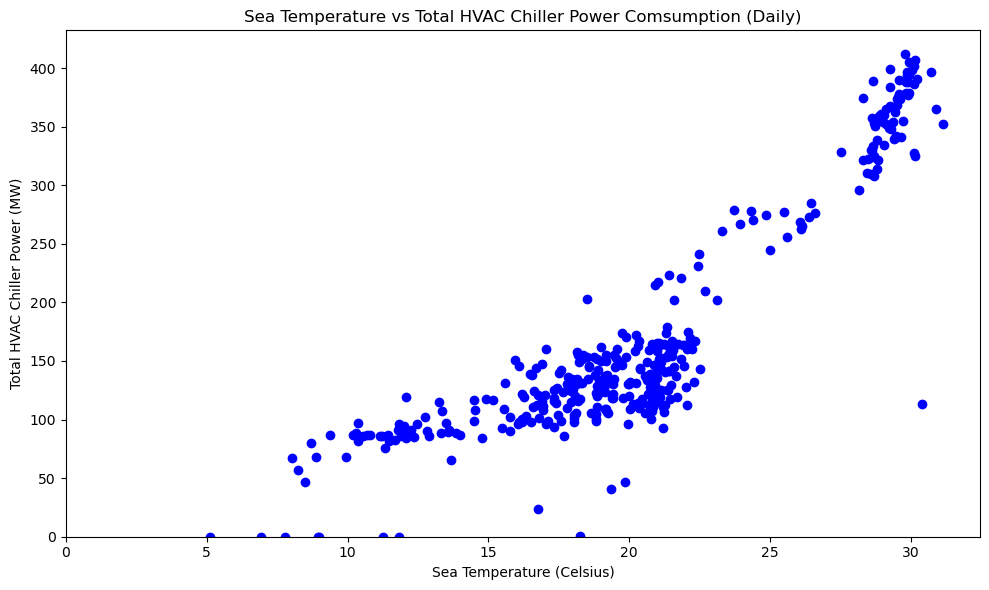

In [30]:
# Calculate the total HVAC chiller power consumption components for Vessel 2
df2['Total HVAC Chiller Power (MW)'] = df2[['HVAC Chiller 1 Power (MW)', 'HVAC Chiller 2 Power (MW)', 'HVAC Chiller 3 Power (MW)']].sum(axis=1)

# Convert 'Start Time' to day format for details
df2['Start Day'] = df2['Start Time'].dt.to_period('D')

# Group by day to aggregate HVAC chiller power consumption and average sea temperature
daily_data_hvac = df2.groupby('Start Day').agg({
    'Total HVAC Chiller Power (MW)': 'sum',
    'Sea Temperature (Celsius)': 'mean'  # Average sea temperature for the day
}).reset_index()

# Create a scatter plot
plt.figure(figsize=(10, 6))

# Scatter plot of Sea Temperature vs Total HVAC Power
plt.scatter(daily_data_hvac['Sea Temperature (Celsius)'], daily_data_hvac['Total HVAC Chiller Power (MW)'], color='blue')

# Set x-axis and y-axis to start at 0
plt.xlim(0, None) 
plt.ylim(0, None) 

# Add labels and title
plt.xlabel('Sea Temperature (Celsius)')
plt.ylabel('Total HVAC Chiller Power (MW)')
plt.title('Sea Temperature vs Total HVAC Chiller Power Comsumption (Daily)')

# Show the plot
plt.tight_layout()
plt.show()


Insights:

For the graph of vessel 2, the relationship between **Average Sea Temperature (°C)** and **Total HVAC Chiller Power (MW)** shows a clear upward trend. This indicates that as the sea temperature rises, the HVAC chiller system consumes more power to maintain desired conditions onboard. The correlation suggests that HVAC power consumption increases proportionally with the increase in sea temperature.

Analysis OF Power Generation

Stationary Vs Moving Diesel Generator

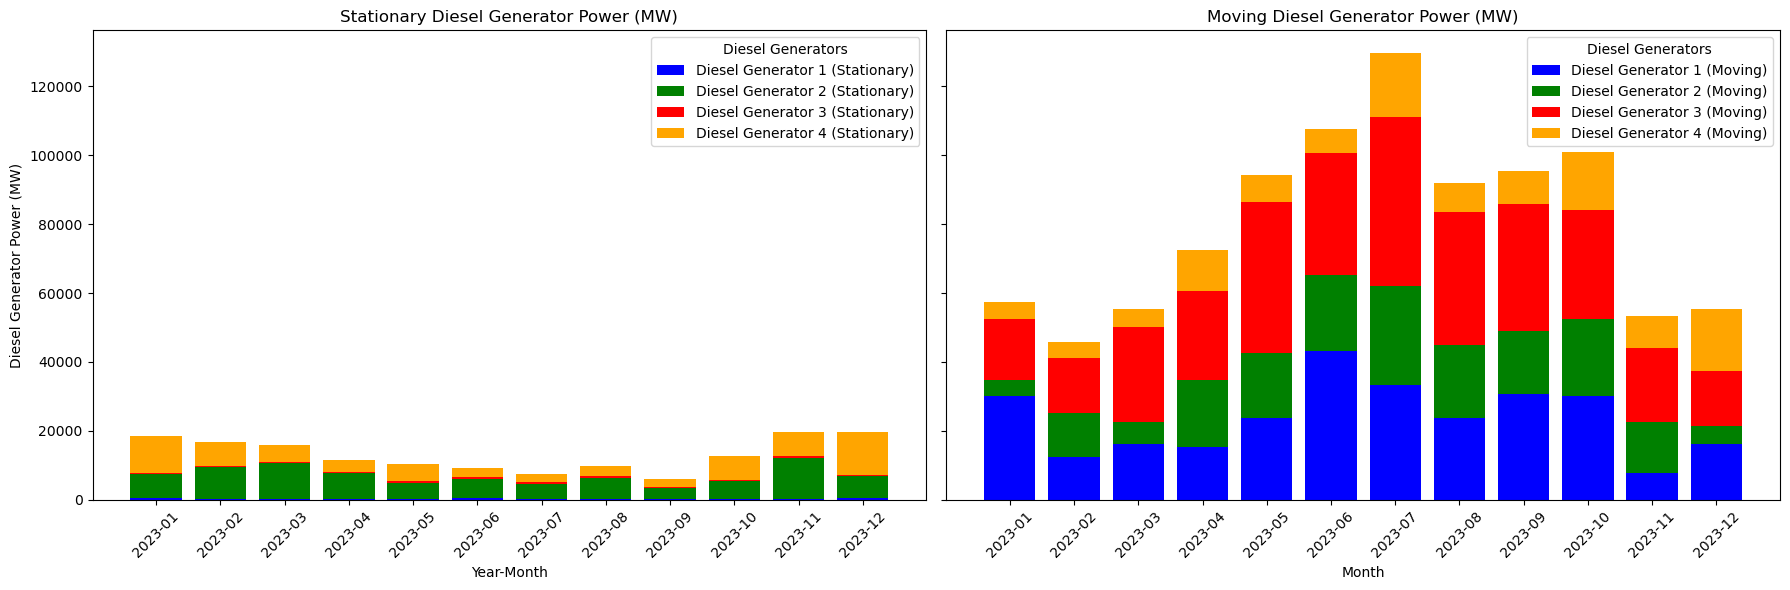

In [31]:
# Ensure 'Start Time' is in datetime format
df2['Start Time'] = pd.to_datetime(df2['Start Time'], errors='coerce')

# Extract Year-Month for grouping
df2['Year-Month'] = df2['Start Time'].dt.to_period('M')

# Create the "Stationary vs. Non-Stationary" calculated field
df2['Stationary vs Non-Stationary'] = df2['Speed Through Water (knots)'].apply(lambda x: 'Moving' if x > 0.1 else 'Stationary')

# Group by Year-Month and 'Stationary vs Non-Stationary', and calculate sum of Diesel Generators 1-4
grouped_data = df2.groupby(['Year-Month', 'Stationary vs Non-Stationary'])[['Diesel Generator 1 Power (MW)', 
                                                                             'Diesel Generator 2 Power (MW)', 
                                                                             'Diesel Generator 3 Power (MW)', 
                                                                             'Diesel Generator 4 Power (MW)']].sum()

# Unstack the 'Stationary vs Non-Stationary' to prepare data for bar plot
unstacked_data = grouped_data.unstack(level=-1)

# Select the "Stationary" and "Moving" data for the graph
stationary_data = unstacked_data.xs('Stationary', level='Stationary vs Non-Stationary', axis=1)
moving_data = unstacked_data.xs('Moving', level='Stationary vs Non-Stationary', axis=1)

# Create the side-by-side plot (2 subplots)
fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

# Define positions for the bars
positions = np.arange(len(stationary_data))

# Plot for Stationary
axes[0].bar(positions, stationary_data['Diesel Generator 1 Power (MW)'], label='Diesel Generator 1 (Stationary)', color='blue')
axes[0].bar(positions, stationary_data['Diesel Generator 2 Power (MW)'], bottom=stationary_data['Diesel Generator 1 Power (MW)'], label='Diesel Generator 2 (Stationary)', color='green')
axes[0].bar(positions, stationary_data['Diesel Generator 3 Power (MW)'], bottom=stationary_data['Diesel Generator 1 Power (MW)'] + stationary_data['Diesel Generator 2 Power (MW)'], label='Diesel Generator 3 (Stationary)', color='red')
axes[0].bar(positions, stationary_data['Diesel Generator 4 Power (MW)'], bottom=stationary_data['Diesel Generator 1 Power (MW)'] + stationary_data['Diesel Generator 2 Power (MW)'] + stationary_data['Diesel Generator 3 Power (MW)'], label='Diesel Generator 4 (Stationary)', color='orange')

axes[0].set_title('Stationary Diesel Generator Power (MW)')
axes[0].set_xlabel('Year-Month')
axes[0].set_ylabel('Diesel Generator Power (MW)')
axes[0].set_xticks(positions)
axes[0].set_xticklabels(stationary_data.index, rotation=45)
axes[0].legend(title='Diesel Generators')

# Plot for Moving
axes[1].bar(positions, moving_data['Diesel Generator 1 Power (MW)'], label='Diesel Generator 1 (Moving)', color='blue')
axes[1].bar(positions, moving_data['Diesel Generator 2 Power (MW)'], bottom=moving_data['Diesel Generator 1 Power (MW)'], label='Diesel Generator 2 (Moving)', color='green')
axes[1].bar(positions, moving_data['Diesel Generator 3 Power (MW)'], bottom=moving_data['Diesel Generator 1 Power (MW)'] + moving_data['Diesel Generator 2 Power (MW)'], label='Diesel Generator 3 (Moving)', color='red')
axes[1].bar(positions, moving_data['Diesel Generator 4 Power (MW)'], bottom=moving_data['Diesel Generator 1 Power (MW)'] + moving_data['Diesel Generator 2 Power (MW)'] + moving_data['Diesel Generator 3 Power (MW)'], label='Diesel Generator 4 (Moving)', color='orange')

axes[1].set_title('Moving Diesel Generator Power (MW)')
axes[1].set_xlabel('Month')
axes[1].set_xticks(positions)
axes[1].set_xticklabels(moving_data.index, rotation=45)
axes[1].legend(title='Diesel Generators')

# Tight layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()


Insights:

1. When the vessel is stationary, Diesel Generators 2 and 4 are the primary sources of power, though their overall output remains low compared to when the vessel is in motion.
2. Diesel Generators 1 and 3 show minimal power generation during stationary conditions, suggesting a limited need for their contribution in this state.
3. During movement, all four generators are heavily utilized, with Diesel Generators 1 and 3 providing the largest share of power.
4. There is a significant increase in power consumption when the vessel is moving, particularly from January to June, with all generators contributing.
5. The side-by-side comparison highlights the stark difference in power demands between stationary and moving conditions, with much higher energy consumption and generator utilization while the vessel is in motion.